In [1]:
import torch

In [2]:
import sys
sys.path.append('clustering/')
from utils import *
import os

In [4]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 加载 embedding
embedding_file = '/home/lyuzhuoqi/projects/clustering/data/2010s/GNN/GNN_embeddings.pt'
embeddings = torch.load(embedding_file, map_location='cpu')
embeddings.shape

/tmp/ipykernel_661556/2360395293.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(embedding_file, map_location='cpu')


torch.Size([37595, 128])

In [5]:
from sklearn.manifold import TSNE
emb_2d = TSNE(n_components=2).fit_transform(embeddings.numpy())

In [6]:
import json

with open('/home/lyuzhuoqi/projects/clustering/data/2010s/direct_citation/vid_to_index.json', 'r') as f:
    vid_to_index = json.load(f)
vid_to_index

{'173952182.0': 0,
 '1127419992.0': 1,
 '2755639217.0': 2,
 '195356620.0': 3,
 '99535875.0': 4,
 '113449338.0': 5,
 '1196868077.0': 6,
 '26277462.0': 7,
 '2755612976.0': 8,
 '2312674.0': 9,
 '40639335.0': 10,
 '2764430319.0': 11,
 '2755952065.0': 12,
 '81453128.0': 13,
 '22240167.0': 14,
 '198727964.0': 15,
 '1175727152.0': 16,
 '2764481359.0': 17,
 '2759168861.0': 18,
 '122096800.0': 19,
 '2736389702.0': 20,
 '2764994983.0': 21,
 '170977379.0': 22,
 '98107870.0': 23,
 '187416585.0': 24,
 '2764491503.0': 25,
 '2898580591.0': 26,
 '89143414.0': 27,
 '1140961231.0': 28,
 '134644764.0': 29,
 '43790123.0': 30,
 '2756351210.0': 31,
 '1123621769.0': 32,
 '2755385796.0': 33,
 '7571225.0': 34,
 '1176326080.0': 35,
 '2754527366.0': 36,
 '2755575508.0': 37,
 '171625771.0': 38,
 '2757547734.0': 39,
 '134546602.0': 40,
 '1167275352.0': 41,
 '126530969.0': 42,
 '138241747.0': 43,
 '146636433.0': 44,
 '2739193000.0': 45,
 '168512209.0': 46,
 '1134271186.0': 47,
 '2764907572.0': 48,
 '205684615.0': 4

In [7]:
len(vid_to_index)

43982

In [8]:
from torch_geometric.data import Data
from gensim.models import KeyedVectors
import scipy.sparse as sp

def load_large_graph():
    """
    Load the large graph using pre-stored node vectors from gensim.models.KeyedVectors.
    
    Steps:
    1. Load the vid_to_index mapping which maps a vertex ID (VID) to its index in the citation matrix.
    2. Load the citation matrix (sparse format).
    3. Load the pre-trained node vectors from gensim.
    4. Filter nodes that do not have a representation in the keyed vectors.
    5. Adjust the citation matrix and node features accordingly.
    """
    # Load the vertex id to index mapping
    mapping_path = '/home/lyuzhuoqi/projects/clustering/data/2010s/direct_citation/vid_to_index.json'
    with open(mapping_path, 'r') as f:
        vid_to_index = json.load(f)
    print("VID to index mapping loaded successfully!")
    
    # Load KeyedVectors (assumed to be stored at the following path)
    vectors_path = '/home/lyuzhuoqi/projects/clustering/data/2010s/Word2Vec/vectors.kv'
    kv_model = KeyedVectors.load(vectors_path, mmap='r')
    print("Gensim KeyedVectors loaded successfully!")
    
    # Identify valid nodes: those whose vertex id exists in the KeyedVectors
    valid_vids = []
    valid_old_indices = []  # original indices in the citation matrix
    for vid, idx in vid_to_index.items():
        # Only use nodes that have a vector in the keyed vectors
        if int(float(vid)) in kv_model:
            valid_vids.append(int(float(vid)))
            valid_old_indices.append(idx)
    
    valid_old_indices = np.array(sorted(valid_old_indices))
    print(f"Filtered valid nodes: {len(valid_old_indices)} out of {len(vid_to_index)}")
    
    # Load the sparse citation matrix
    loaded_data = np.load('/home/lyuzhuoqi/projects/clustering/data/2010s/direct_citation/citation_matrix.npz')
    num_nodes_total = len(vid_to_index)
    citation_matrix = sp.coo_matrix(
        (loaded_data['data'], (loaded_data['row'], loaded_data['col'])),
        shape=(num_nodes_total, num_nodes_total)
    )
    print("Citation matrix loaded successfully!")
    
    # Filter the citation matrix to only include rows and columns corresponding to valid nodes
    citation_matrix = citation_matrix.tocsr()[valid_old_indices, :][:, valid_old_indices]
    citation_matrix = citation_matrix.tocoo()
    
    # Build edge_index from the filtered citation matrix
    edge_index = torch.tensor(np.array([citation_matrix.row, citation_matrix.col]), dtype=torch.long)
    edge_attr = torch.tensor(citation_matrix.data, dtype=torch.float)
    
    # Build node features from keyed vectors for valid nodes.
    # Create a new sorted mapping: For each valid old index, find the corresponding vid,
    # then get the vector from the KeyedVectors.
    # We need an inverse mapping from original index to vertex id.
    index_to_vid = {int(idx): int(float(vid)) for vid, idx in vid_to_index.items()}
    node_features = []
    for idx in valid_old_indices:
        vid = index_to_vid[int(idx)]
        vec = kv_model[vid]
        node_features.append(vec)
    
    node_features = torch.tensor(np.vstack(node_features), dtype=torch.float)
    
    # Create a PyG Data object with the filtered citation matrix and corresponding features.
    data = Data(edge_index=edge_index, edge_attr=edge_attr, x=node_features)
    
    return data, valid_old_indices

In [9]:
_, valid_old_indices = load_large_graph()

VID to index mapping loaded successfully!
Gensim KeyedVectors loaded successfully!
Filtered valid nodes: 37595 out of 43982
Citation matrix loaded successfully!


In [10]:
len(valid_old_indices)

37595

In [11]:
index_to_vid = {int(idx): int(float(vid)) for vid, idx in vid_to_index.items()}
index_to_vid

{0: 173952182,
 1: 1127419992,
 2: 2755639217,
 3: 195356620,
 4: 99535875,
 5: 113449338,
 6: 1196868077,
 7: 26277462,
 8: 2755612976,
 9: 2312674,
 10: 40639335,
 11: 2764430319,
 12: 2755952065,
 13: 81453128,
 14: 22240167,
 15: 198727964,
 16: 1175727152,
 17: 2764481359,
 18: 2759168861,
 19: 122096800,
 20: 2736389702,
 21: 2764994983,
 22: 170977379,
 23: 98107870,
 24: 187416585,
 25: 2764491503,
 26: 2898580591,
 27: 89143414,
 28: 1140961231,
 29: 134644764,
 30: 43790123,
 31: 2756351210,
 32: 1123621769,
 33: 2755385796,
 34: 7571225,
 35: 1176326080,
 36: 2754527366,
 37: 2755575508,
 38: 171625771,
 39: 2757547734,
 40: 134546602,
 41: 1167275352,
 42: 126530969,
 43: 138241747,
 44: 146636433,
 45: 2739193000,
 46: 168512209,
 47: 1134271186,
 48: 2764907572,
 49: 205684615,
 50: 2755724983,
 51: 2754637869,
 52: 182449769,
 53: 208012136,
 54: 1164009877,
 55: 1171805742,
 56: 154286738,
 57: 2758995940,
 58: 42926609,
 59: 1138890651,
 60: 98647789,
 61: 2754197539,


In [12]:
vids = []
for idx in valid_old_indices:
    vids.append(index_to_vid[idx])

In [13]:
len(vids)

37595

In [14]:
import pandas as pd
plot_df = pd.DataFrame(emb_2d, columns=['x', 'y'])
plot_df['vid'] = list(vids)
plot_df = plot_df.merge(pd.read_parquet(os.path.join(get_data_dir(), 'MAG_venue.parquet'))[['OriginalVenue', 'VenueType']], left_on='vid', right_index=True)
plot_df.rename(columns={'OriginalVenue': 'venue', 'VenueType': 'type'}, inplace=True)
plot_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,x,y,vid,venue,type
0,107.375725,-1.311840,173952182,Physics Letters B,Journal
1,74.076431,-58.850388,1127419992,international conference on human-computer int...,Conference
2,3.982694,66.348236,2755639217,The Journal of the Japanese Association for In...,Journal
3,54.751736,58.357536,195356620,Experimental & Clinical Cardiology,Journal
4,26.121578,38.265507,99535875,Minerva Chirurgica,Journal
...,...,...,...,...,...
37590,-64.455521,19.015270,2764653392,Modern Problems of Science and Education,Journal
37591,-82.562172,12.160774,2764695885,Russian Journal of Entrepreneurship,Journal
37592,-82.627388,12.329038,2764506137,VESTNIK OF VORONEZH STATE AGRARIAN UNIVERSITY,Journal
37593,-45.702286,33.797749,2765071923,European science,Journal


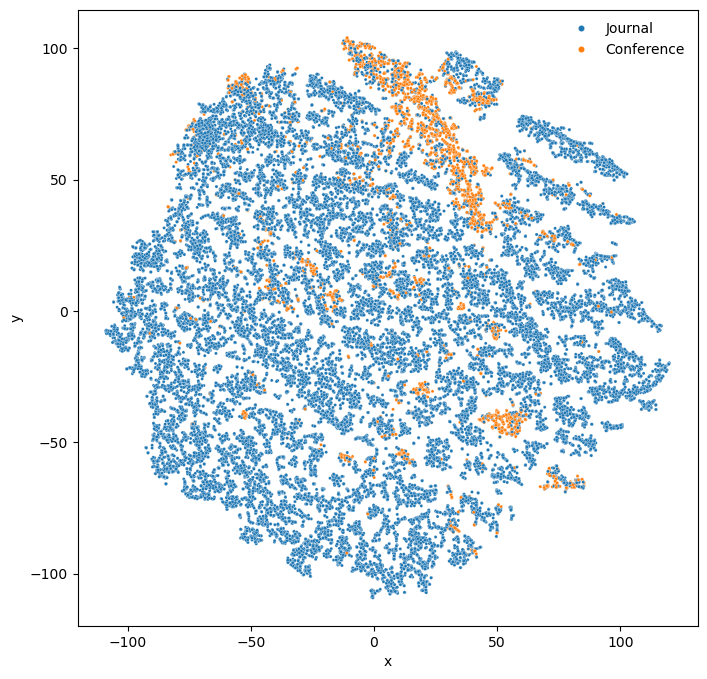

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(data=plot_df, x='x', y='y', hue='type', s=5)
plt.legend(frameon=False, markerscale=2)

In [16]:
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), '2010s', 'clustering_results', 'cluster_df.parquet'))
plot_df = plot_df.merge(cluster_df['Scopus_label'], left_on='vid', right_index=True)
plot_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,x,y,vid,venue,type,Scopus_label
0,107.375725,-1.311840,173952182,Physics Letters B,Journal,Physics and Astronomy
4,26.121578,38.265507,99535875,Minerva Chirurgica,Journal,Medicine
5,31.886431,19.464735,113449338,Journal of Shanghai Jiaotong University (science),Journal,Multidisciplinary
7,34.576534,-48.355389,26277462,International Journal of Agriculture and Biology,Journal,Agricultural and Biological Sciences
9,106.078781,-17.548170,2312674,Journal of Trauma-injury Infection and Critica...,Journal,Medicine
...,...,...,...,...,...,...
37570,-59.333988,61.400990,13479866,Archives of Environmental Health,Journal,Medicine
37572,-70.817101,60.912659,2754129969,ACP journal club,Journal,Medicine
37573,-93.932350,20.690796,2764567929,Contemporary linguistics,Journal,Social Sciences
37581,-12.801641,52.845245,2764551302,Gornyi Zhurnal,Journal,Earth and Planetary Sciences


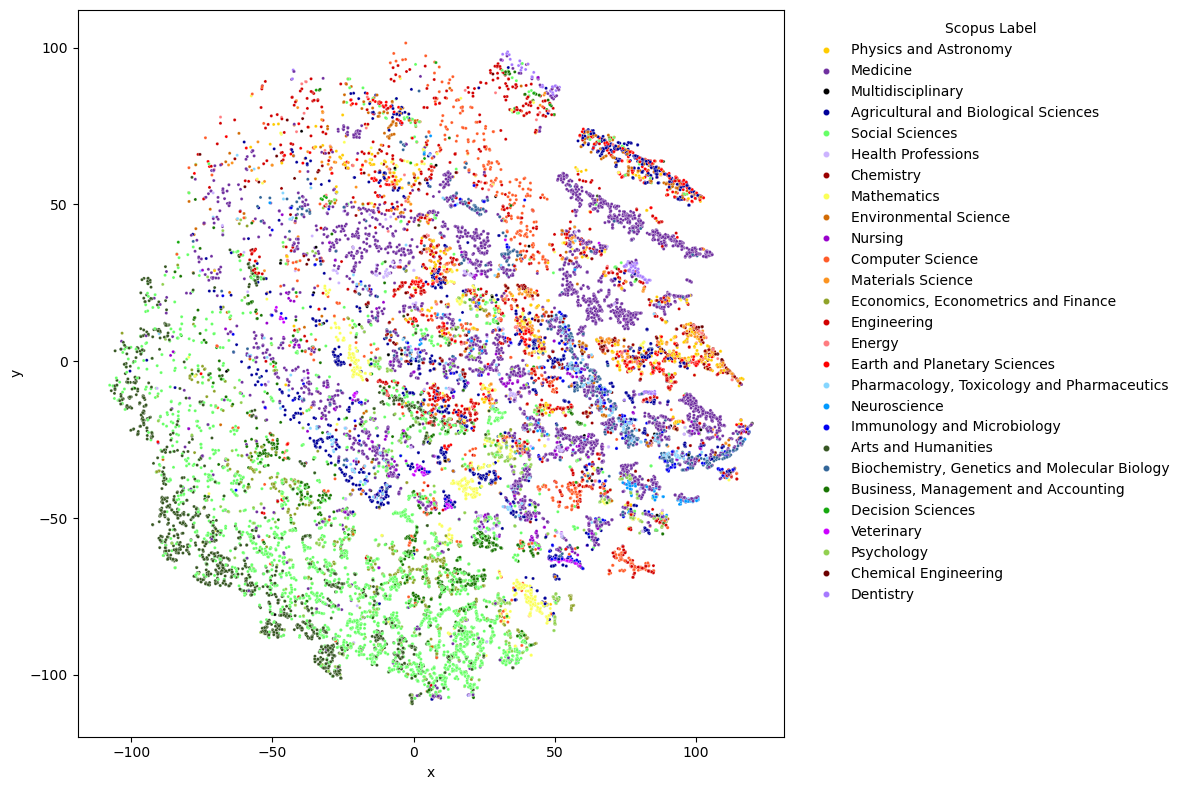

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with a specific size
fig = plt.figure(figsize=(12, 8))

# Create the main scatter plot in the left part
ax_scatter = plt.subplot2grid((1, 5), (0, 0), colspan=4)
scatter = sns.scatterplot(data=plot_df, x='x', y='y', s=5, hue='Scopus_label', palette=Scopus2color, ax=ax_scatter)
ax_scatter.legend_.remove()  # Remove the legend from the scatter plot

# Create a separate axis for the legend on the right
ax_legend = plt.subplot2grid((1, 5), (0, 4))
handles, labels = scatter.get_legend_handles_labels()
ax_legend.legend(handles, labels, title='Scopus Label', frameon=False,
                 bbox_to_anchor=(0, 1), loc='upper left', markerscale=2)
ax_legend.axis('off')  # Hide the axis

plt.tight_layout()

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=26, random_state=42).fit(embeddings.numpy())
kmeans.labels_

array([ 4, 25,  1, ...,  1,  1,  1], dtype=int32)

In [19]:
import pandas as pd

gnn_kmeans_df = pd.DataFrame(kmeans.labels_, columns=['gnn_kmeans_label'])
gnn_kmeans_df['vid'] = vids
gnn_kmeans_df = gnn_kmeans_df.merge(pd.read_parquet(os.path.join(get_data_dir(), 'MAG_venue.parquet'))[['OriginalVenue', 'VenueType']], left_on='vid', right_index=True)
gnn_kmeans_df.rename(columns={'OriginalVenue': 'venue', 'VenueType': 'type'}, inplace=True)
gnn_kmeans_df.set_index('vid', inplace=True)
gnn_kmeans_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,gnn_kmeans_label,venue,type
vid,,,
173952182,4,Physics Letters B,Journal
1127419992,25,international conference on human-computer int...,Conference
2755639217,1,The Journal of the Japanese Association for In...,Journal
195356620,1,Experimental & Clinical Cardiology,Journal
99535875,1,Minerva Chirurgica,Journal
...,...,...,...
2764653392,1,Modern Problems of Science and Education,Journal
2764695885,1,Russian Journal of Entrepreneurship,Journal
2764506137,1,VESTNIK OF VORONEZH STATE AGRARIAN UNIVERSITY,Journal


In [20]:
cluster_df = pd.read_parquet(os.path.join(get_data_dir(), '2010s', 'clustering_results', 'cluster_df.parquet'))
if 'gnn_kmeans_label' in cluster_df.columns:
    cluster_df.drop(columns='gnn_kmeans_label', inplace=True)
cluster_df = cluster_df.merge(gnn_kmeans_df['gnn_kmeans_label'], left_index=True, right_index=True)
cluster_df

data_dir:  /home/lyuzhuoqi/projects/clustering/data


,Scopus_label,movMF_label,movMF_distance,x_val,y_val,kmeans_label,kmeans_distance,skm_label,skm_distance,spectral_label,n2v_kmeans_label,cm_kmeans_label,bert_kmeans_label,gnn_kmeans_label
202381698,Multidisciplinary,22,0.445886,-67.928200,15.572327,17,0.628846,20,0.444711,24,3,21,18,3
137773608,Multidisciplinary,22,0.590942,-68.405334,-55.633186,17,0.735654,20,0.559494,24,20,21,8,2
125754415,Multidisciplinary,22,0.574571,-68.448853,-55.613579,17,0.705024,20,0.550081,24,20,21,8,2
3880285,Multidisciplinary,23,0.618842,-68.407288,-55.634430,8,0.724859,17,0.610582,24,20,21,18,20
111155417,Chemistry,23,0.220853,-54.506985,-61.217068,11,0.495787,12,0.198758,14,4,24,6,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764485818,Medicine,21,0.268070,-28.969574,34.819569,18,0.542531,14,0.251015,8,18,1,23,1
83454320,Arts and Humanities,25,0.034777,78.609909,31.736822,13,0.251599,3,0.056642,21,5,1,23,1
16507453,Arts and Humanities,6,0.113656,89.206772,17.625090,13,0.307089,3,0.128660,21,5,1,23,1
121509672,Agricultural and Biological Sciences,5,0.179111,-36.757057,-0.591017,21,0.430040,16,0.207435,10,5,1,23,1


In [21]:
cluster_df.to_parquet(os.path.join(get_data_dir(), '2010s', 'clustering_results', 'cluster_df.parquet'))

data_dir:  /home/lyuzhuoqi/projects/clustering/data
